In [1]:
%load_ext autoreload
%autoreload 2

# add src to sys-path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./src')
from matplotlib.pyplot import figure
from geopy.distance import geodesic
from sklearn.decomposition import PCA

from data_processing.mtb_data_provider import MtbDataProvider
from data_processing.mtb_data_tagger import MtbDataTagger
from data_processing.mtb_classifier import MtbClassifier
from visualization.mtb_visualizer import MtbVisualizer
from data_processing.helpers import Helpers

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.utils import shuffle

from numpy.random import seed
import tensorflow
tensorflow.random.set_seed(42)
seed(42)
np.random.seed(42)

SPEED_THRESHOLD = .3
LATITUDE_KEY = 'position_lat'
LONGITUDE_KEY = 'position_long'

In [ ]:
df = pd.read_csv('data/warngau_s2_labels_2.csv')

lats = df['latitude'].values
lons = df['longitude'].values

data = []
last_coordinates = (0,0)
for value_set in df.values:
    coordinates = (value_set[0], value_set[1])
    # Join the labels to one string
    new_value_set = np.hstack([value_set[:2], '-'.join(value_set[2:5]), value_set[-1]])
    
    # When changing labels, the app writes each change. Just take the latest label for one position in this case
    if coordinates == last_coordinates:
        data[-1] = new_value_set
    else:
        data.append(new_value_set)
        last_coordinates = coordinates
        

le = preprocessing.LabelEncoder()
data = np.array(data)
encoded_labels = le.fit_transform(data[:, 2])

labels, counts = np.unique(data[:, 2], return_counts=True)
counts > 3
labels = labels[counts>=5]
#data = data[data[:, 2] in labels]
#for d in data[:, 2] if d in labels
#len(data)
list(filter(lambda dic: dic[2] in labels, data))
    


In [3]:
mtb_data_provider = MtbDataProvider()
mtb_data_tagger = MtbDataTagger()
mtb_visualizer = MtbVisualizer()
mtb_classifier = MtbClassifier()

## Data Export

In [4]:
files=['dandlberg']#, 'warngaus2_2']#'warngaus1_1', 'warngaus1_2', 'warngaus1_3', 
location_based_label_files=['dandlberg_labels']
columns = ['SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD','altitude', 'speed', 'heart_rate', 'SensorHeading', LATITUDE_KEY, LONGITUDE_KEY]
#gopro_columns = ['AcclX','AcclY','AcclZ','Altitude','Speed','Speed3D','GyroX','GyroY','GyroZ', 'Latitude','Longitude']
gopro_columns = ['Milliseconds']
gopro_sync_files = ["gps"]#["accl", "gps", "gyro"]
window_lengths = [50]#, 150, 300]
sub_sample_lengths = [25]#, 75, 150]
nums_clusters = [3]#, 4, 6, 9]
prefix='dandlberg'

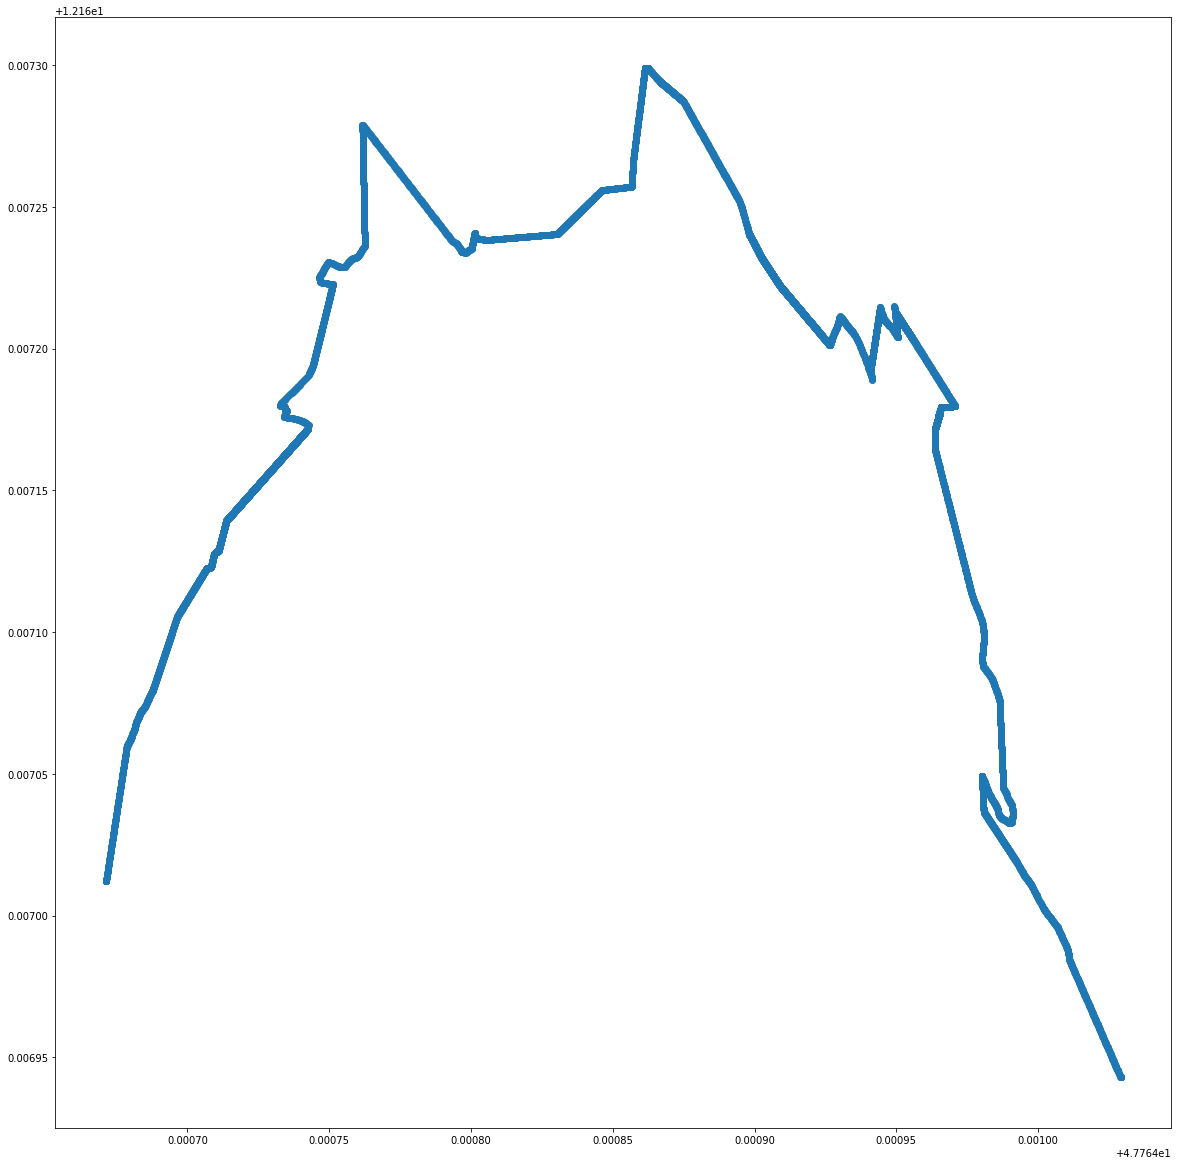

In [57]:
df = pd.read_csv('data/dandlberg_gopro.csv')
latitude = df['Latitude'].values
longitude = df['Longitude'].values

geometry = gpd.points_from_xy(latitude, longitude)
gdf = GeoDataFrame(geometry=geometry)
gdf.plot(figsize=(20, 30))
plt.show()


In [63]:
if True:
    mtb_data_provider.prepare_and_save_samples(
        files, 
        columns, 
        gopro_columns=gopro_columns,
        gopro_sync_files=gopro_sync_files,
        location_based_label_files=location_based_label_files, 
        prefix=prefix, 
        window_lengths=window_lengths, 
        sub_sample_lengths=sub_sample_lengths, 
        force_overwrite=True,
        auto_padd_left_right=True,
        min_cluster_size=1)

Preparing raw data...
Converting fit file data/dandlberg
Found mp4 file. Converting and syncing ...
Converting gopro mp4 file data/dandlberg


/usr/local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1092: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


Syncing data and gopro data...


[-8.57177033e+00  8.49282297e-01 -4.87320574e+00  5.55601000e+02
  7.60000000e-02  9.00000000e-02  2.55659121e-02 -1.00133156e-01
  7.64314248e-02  4.77646713e+01  1.21670121e+01]



NameError: name 'exit' is not defined

In [7]:
import subprocess
subprocess.Popen(['vlc-ctrl',  'play',  '/Users/stefanlanger/projects/artificial-intelligence/fittest/data/warngaus2_1.mp4'])

FileNotFoundError: [Errno 2] No such file or directory: 'vlc-ctrl'

In [ ]:
import vlc

# Create Player Object and set MRL (your_video.mp4)
player = vlc.MediaPlayer('/Users/stefanlanger/projects/artificial-intelligence/fittest/data/warngaus2_1.mp4')
player.play()
time.sleep(10)
player.stop()

In [ ]:
timestamps = np.load('data/warngau_s2_50_25_timestamps.npy')
print(timestamps)

for i in range(len(timestamps)):
    timestamp = timestamps[i] / 1000
    next_timestamp = timestamps[i+1] / 1000
    diff = next_timestamp-timestamp
    print(diff)
    time.sleep(diff)
    

### TODOS

 - [ ] Add Timestamp to data, but do not train on it
 - [ ] Currently labels data in 3 categories (steepness, roughness, ...): Change for Bikepark labels somehow
 - [ ] Test with real data
 - [ ] How to display resulting Cluster next to video? Start video play and cluster label play simultaneously?

## FI Clustering

In [ ]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

mtb_classifier.train_and_compare_unsupervised_clusterings(
    mtb_data_provider, 
    nums_clusters=nums_clusters, 
    prefix=prefix, 
    run_dec=False,
    run_fidec=False,
    run_dcec=False,
    run_fidcec=False,
    run_classical_raw=False,
    run_classical_raw_fi=False,
    run_classical_features=False,
    run_cael2 = True,
    run_cael2fi = True,
    cael2_filters=[32, 64, 128],
#    dec_dims=[500, 1000, 3000, 7],
#    dcec_filters=[32, 64, 128],
#    pretrain_epochs = 300,
#    maxiter = 6e4,
#    dec_dims=[500, 500, 2000, 7],
#    dcec_filters=[32, 64, 128],
#    update_interval = 140,
#    pretrain_epochs = 300,
#    maxiter = 2e4,
#    init=VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform'),
#    pretrain_optimizer=SGD(lr=1, momentum=0.9),
#    maxiter=1,
    window_lengths=window_lengths, 
    sub_sample_lengths=sub_sample_lengths)

### Evaluation

In [ ]:
def plot_scores(score_keys, window_lengths, sub_sample_lengths, scores):
    for score_key in score_keys:
        for window_length in window_lengths:
            for sub_sample_length in sub_sample_lengths:
                if sub_sample_length >= window_length:
                    continue

                window_prefix = "%s_%s_%s" % (score_key, str(window_length), str(sub_sample_length))

                figure(1, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
                legend = []
                has_data = False
                for key, score_array in scores.items():
                    if window_prefix in key:
                        has_data = True
                        plt.scatter(x=nums_clusters, y=score_array)
                        legend.append(key)
                
                if has_data:
                    print(window_prefix)
                    plt.legend(legend)
                    plt.show()

In [ ]:
def plot_track(prefix, window_length, sub_sample_length, eval_prefixes, experiment_prefix):
    data_prefix = "%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length))
    filename_features = "data/%s_features.npy" % data_prefix
    filename_labels = "data/%s_labels.npy" % data_prefix
    filename_raw = "data/%s_raw.npy" % data_prefix

    feature_file = np.load(filename_features)
    labels = np.load(filename_labels)
    labels = LabelEncoder().fit_transform(labels)
    raw_file = np.load(filename_raw)

    print('---- Ground Truth ----')
    geometry = gpd.points_from_xy(feature_file[:, -1], feature_file[:, -2])
    gdf = GeoDataFrame(geometry=geometry)
    gdf.plot(c=labels, figsize=(20, 30))
    plt.show()

    for eval_prefix in eval_prefixes:
        print('---- %s ----' % eval_prefix)
        filename_y_pred = "evaluation/%s_%s_y_pred.npy" % (experiment_prefix, eval_prefix)
        y_pred = np.load(filename_y_pred)
        gdf = GeoDataFrame(geometry=geometry)
        gdf.plot(c=y_pred, figsize=(20, 30))
        plt.show()

In [ ]:
eval_prefixes = ['cael2', 'cael2fi', 'classical_raw', 'classical_raw_fi', 'classical_features', 'dcec', 'fidcec', 'dec', 'fidec']
score_keys = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score', 'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']
score_keys_filter = ['adjusted_rand_score']#, 'robustness']

In [ ]:
def process_results(eval_prefixes, score_keys, score_keys_filter, verbose=True):
    scores = dict()

    for num_clusters in nums_clusters:
        for window_length in window_lengths:
            for sub_sample_length in sub_sample_lengths:
                if sub_sample_length >= window_length:
                    continue

                experiment_prefix = "%s_%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length), str(num_clusters))

                results_complete = None
                for eval_prefix in eval_prefixes:
                    filename_scores = "evaluation/%s_%s_score.csv" % (experiment_prefix, eval_prefix)
                    results = pd.read_csv(filename_scores).values.T
                    results_complete = results if results_complete is None else np.vstack((results_complete, results[-1]))

                    for i in range(len(score_keys)):
                        score_prefix = "%s_%s_%s_%s" % (eval_prefix, score_keys[i], str(window_length), str(sub_sample_length))
                        if not score_prefix in scores:
                            scores[score_prefix] = []
                        scores[score_prefix].append(results[-1][i])


                    # -------- ROBUSTNESS --------
                    if 'robustness' in score_keys_filter:
                        data_prefix = "%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length))
                        filename_y_pred = "evaluation/%s_%s_y_pred.npy" % (experiment_prefix, eval_prefix)
                        filename_features = "data/%s_features.npy" % data_prefix
                        feature_file = np.load(filename_features)
                        y_pred = np.load(filename_y_pred)

                        latitudes, longitudes = feature_file[:, -1], feature_file[:, -2]
                        y_pred_1 = []
                        y_pred_2 = []
                        min_position_delta = int(len(y_pred)/3)

                        for i in range(len(y_pred) - min_position_delta):
                            for j in range(i + min_position_delta, len(y_pred)):
                                location1 = (latitudes[i], longitudes[i])
                                location2 = (latitudes[j], longitudes[j])

                                distance = geodesic(location1, location2).meters
                                if distance < 6:
                                    y_pred_1.append(y_pred[i])
                                    y_pred_2.append(y_pred[j])
                                    continue

                        robustness = metrics.adjusted_rand_score(y_pred_1, y_pred_2)
                        score_prefix = "%s_%s_%s_%s" % (eval_prefix, 'robustness', str(window_length), str(sub_sample_length))
                        if not score_prefix in scores:
                            scores[score_prefix] = []
                        scores[score_prefix].append(robustness)

                        #-----------

                results_complete = results_complete.T
                header = np.hstack(([''], eval_prefixes))
                results_complete = np.insert(results_complete, 0, header, axis=0)

                # --------------------- HEADERS ---------------------
                if verbose:
                    print("----------------------------------------------------------------")
                    print("window_length:", window_length)
                    print("sub_sample_length:", sub_sample_length)
                    print("clusters:", num_clusters)


                    # --------------------- TABLES ---------------------
                    print(pd.DataFrame(results_complete.T), "\n\n")


                    # --------------------- Track PLOTS ---------------------

                    plot_track(prefix, window_length, sub_sample_length, eval_prefixes, experiment_prefix)

    return scores


In [ ]:
def plot_random_samples(prefix, eval_prefix, window_length, sub_sample_length, num_clusters, 
                        num_sub_plots=4,
                       plot_all_in_one=False,
                       plot_each_dimension=True):
    data_prefix = "%s_%s_%s" % (prefix, str(window_length), str(sub_sample_length))
    filename_features = "data/%s_features.npy" % data_prefix
    filename_labels = "data/%s_labels.npy" % data_prefix
    filename_raw = "data/%s_raw.npy" % data_prefix
    experiment_prefix = "%s_%s" % (data_prefix, str(num_clusters))

    feature_file = np.load(filename_features)
    labels = np.load(filename_labels)
    raw_file = np.load(filename_raw)

    #for eval_prefix in eval_prefixes:
    print('---- %s ----' % eval_prefix)
    filename_y_pred = "evaluation/%s_%s_y_pred.npy" % (experiment_prefix, eval_prefix)
    y_pred = np.load(filename_y_pred)

    # -------- Plot All Dimensions In One --------
    if plot_all_in_one:
        for cluster in range(num_clusters):
            mask = y_pred == cluster
            fig, axes = plt.subplots(1,4, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15,3))

            axes[0].set_ylabel('Cluster-%s: %s' % (str(cluster), str(np.sum(mask))))

            indices = np.arange(len(raw_file))[mask]
            raw_samples = raw_file[:, :, :-4][mask]

            indices, raw_samples = shuffle(indices, raw_samples)

            for i, sample, ax in zip(indices, raw_samples, axes):
                ax.plot(sample)
                ax.set_title('Sample: %s' % str(i))

        plt.legend(columns)
        plt.show()
        
    # -------- Plot Dimensions Individually --------
    if plot_each_dimension:
        for i in range(len(columns[:-3])):
            print(columns[i])
            for cluster in range(num_clusters):
                mask = y_pred == cluster
                fig, axes = plt.subplots(1,num_sub_plots, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(15,3))

                axes[0].set_ylabel('Cluster-%s: %s' % (str(cluster), str(np.sum(mask))))

                indices = np.arange(len(raw_file))[mask]

                dimension_data = raw_file[:, :, i][mask]
                indices, dimension_data = shuffle(indices, dimension_data)

                for j, sample, ax in zip(indices, dimension_data, axes):
                    ax.set_ylim([np.min(dimension_data),np.max(dimension_data)]) # TODO: Make this min/max of the selected feature
                    ax.plot(sample if i < 3 else sample[0::25])
                    ax.set_title('Sample: %s' % str(j))
                plt.show()

In [ ]:
scores = process_results(eval_prefixes, score_keys, score_keys_filter, verbose=False)

In [ ]:
plot_scores(score_keys_filter, window_lengths, sub_sample_lengths, scores)

In [ ]:
plot_random_samples(prefix, 'classical_raw_fi', 300, 150, 13)
# TODO: Write labels as text next to the plot